## **Non spin polarised band**

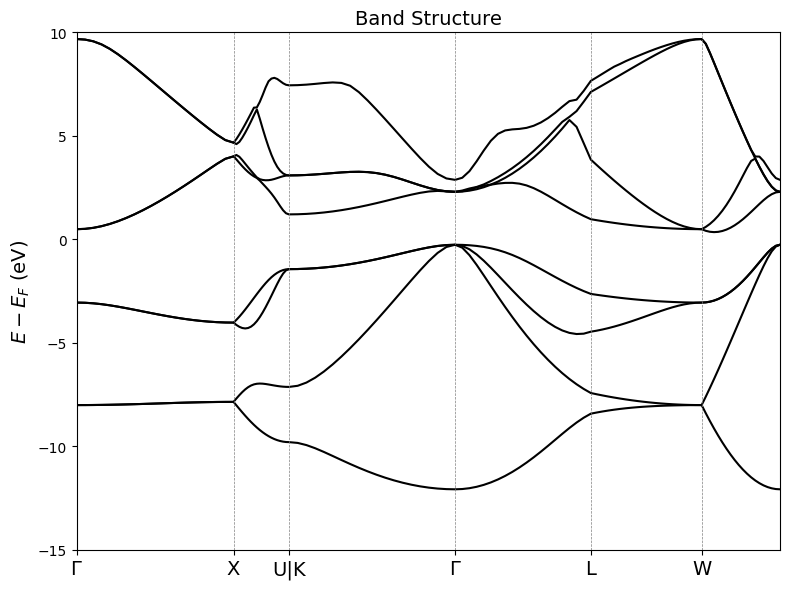

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read band structure data from a .dat file
def read_band_structure(filename):
    k_points = []
    energies = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

            # Read the second line for NKPTS and NBANDS
            nkpts = 0
            nbands = 0
            second_line_parts = lines[1].split()
            if len(second_line_parts) >= 6:
                nkpts = int(second_line_parts[4])  # Get NKPTS
                nbands = int(second_line_parts[5])  # Get NBANDS

            current_band_energies = []  # List to hold energies for the current band
            for line in lines:
                line = line.strip()  # Remove leading and trailing whitespace
                if line.startswith('#') or not line:  # Skip header lines and empty lines
                    continue

                parts = line.split()
                if len(parts) == 2:
                    k_point = float(parts[0])
                    energy = float(parts[1])

                    # Append k-point and energy
                    k_points.append(k_point)
                    current_band_energies.append(energy)

                    # If we've read nkpts energies, save them and start a new band
                    if len(current_band_energies) == nkpts:
                        energies.append(current_band_energies)  # Save the current band
                        current_band_energies = []  # Reset for the next band

        # Convert lists to NumPy arrays
        k_points = np.array(k_points[:nkpts])  # Keep only the first nkpts for k_points
        energies = np.array(energies)  # Convert energies to a 2D array

        # Reverse the order of every alternate band (1st, 3rd, 5th, etc.)
        for band_index in range(energies.shape[0]):
            if band_index % 2 == 0:  # Check if the band index is odd
                energies[band_index] = energies[band_index][::-1]

        return k_points, energies  # k_points will be unique values, energies is a 2D array
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None, None
    except ValueError as e:
        print(f"Error reading data: {e}")
        return None, None

# Function to read k-path labels and positions from a KLABELS file
def read_k_labels(filename):
    labels = []
    positions = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            # Skip the first line (comment line)
            for line in lines[1:]:  # Start from the second line
                line = line.strip()  # Remove any leading or trailing whitespace
                if not line:  # Skip empty lines
                    continue
                parts = line.split()
                if len(parts) == 2:
                    try:
                        label = parts[0]
                        # Replace "GAMMA" with LaTeX-style $\Gamma$
                        if label.upper() == "GAMMA":
                            label = r"$\Gamma$"
                        labels.append(label)
                        positions.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that don't have valid data
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return [], []

    return labels, positions

# Function to plot the band structure
def plot_band_structure(k_points, energies, k_labels, k_positions,
                        font_size=12, line_thickness=1.5,
                        figure_size=(8, 6), energy_range=None):
    plt.figure(figsize=figure_size)

    # Plot each band
    for band_index in range(energies.shape[0]):  # Iterate over each band
        plt.plot(k_points, energies[band_index], color='black', linewidth=line_thickness)

    # Customize the plot
    #plt.xlabel('k-path', fontsize=font_size)
    plt.ylabel('$E-E_F$ (eV)', fontsize=font_size)
    plt.title('Band Structure', fontsize=font_size)

    # Set x-ticks at k-label positions
    plt.xticks(k_positions, k_labels, fontsize=font_size)

    # Draw vertical lines at k-label positions
    for pos in k_positions:
        plt.axvline(x=pos, color='gray', linestyle='--', linewidth=0.5)

    # Set energy range if provided
    if energy_range:
        plt.ylim(energy_range)
    plt.xlim(min(k_points), max(k_points))

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
band_file = 'BAND.dat'  # Replace with your .dat file name
klabels_file = 'KLABELS'  # Replace with your KLABELS file name

# Read data from files
k_points, energies = read_band_structure(band_file)
k_labels, k_positions = read_k_labels(klabels_file)

# Customize plot parameters as needed
if k_points is not None and energies is not None:
    plot_band_structure(
        k_points, energies, k_labels, k_positions,
        font_size=14, line_thickness=1.5, figure_size=(8, 6),
        energy_range=(-15, 10)  # Adjust the energy range as needed
    )

## **Spin polarised band**

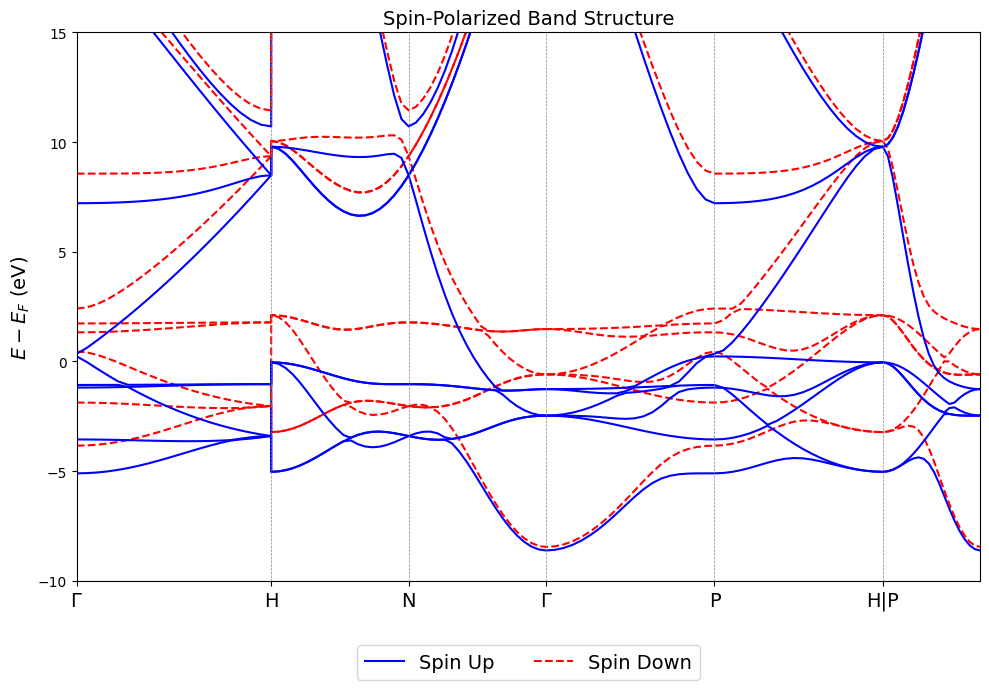

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read spin-polarized band structure data from a .dat file
def read_spin_polarized_band_structure(filename):
    k_points = []
    energies_up = []
    energies_down = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

            # Read the second line for NKPTS and NBANDS
            nkpts = 0
            nbands = 0
            second_line_parts = lines[1].split()
            if len(second_line_parts) >= 6:
                nkpts = int(second_line_parts[4])  # Get NKPTS
                nbands = int(second_line_parts[5])  # Get NBANDS

            current_band_energies_up = []   # Energies for spin-up
            current_band_energies_down = [] # Energies for spin-down
            for line in lines:
                line = line.strip()  # Remove leading and trailing whitespace
                if line.startswith('#') or not line:  # Skip header lines and empty lines
                    continue

                parts = line.split()
                if len(parts) == 3:  # Expecting k-point, energy_up, and energy_down
                    k_point = float(parts[0])
                    energy_up = float(parts[1])
                    energy_down = float(parts[2])

                    # Append k-point and energies
                    k_points.append(k_point)
                    current_band_energies_up.append(energy_up)
                    current_band_energies_down.append(energy_down)

                    # If we've read nkpts energies, save them and start a new band
                    if len(current_band_energies_up) == nkpts:
                        energies_up.append(current_band_energies_up)   # Save spin-up energies
                        energies_down.append(current_band_energies_down) # Save spin-down energies
                        current_band_energies_up = []   # Reset for the next band
                        current_band_energies_down = [] # Reset for the next band

        # Convert lists to NumPy arrays
        k_points = np.array(k_points[:nkpts])  # Keep only the first nkpts for k_points
        energies_up = np.array(energies_up)     # Convert energies_up to a 2D array
        energies_down = np.array(energies_down) # Convert energies_down to a 2D array

        # Reverse the order of every alternate band for spin-up and spin-down
        for band_index in range(energies_up.shape[0]):
            if band_index % 2 == 0:  # Check if the band index is even
                energies_up[band_index] = energies_up[band_index][::-1]
                energies_down[band_index] = energies_down[band_index][::-1]

        return k_points, energies_up, energies_down
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None, None, None
    except ValueError as e:
        print(f"Error reading data: {e}")
        return None, None, None

# Function to read k-path labels and positions from a KLABELS file
def read_k_labels(filename):
    labels = []
    positions = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            # Skip the first line (comment line)
            for line in lines[1:]:  # Start from the second line
                line = line.strip()  # Remove any leading or trailing whitespace
                if not line:  # Skip empty lines
                    continue
                parts = line.split()
                if len(parts) == 2:
                    try:
                        label = parts[0]
                        # Replace "GAMMA" with LaTeX-style $\Gamma$
                        if label.upper() == "GAMMA":
                            label = r"$\Gamma$"
                        labels.append(label)
                        positions.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that don't have valid data
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return [], []

    return labels, positions

# Function to plot the spin-polarized band structure
def plot_spin_polarized_band_structure(k_points, energies_up, energies_down, k_labels, k_positions,
                                       font_size=12, line_thickness=1.5,
                                       figure_size=(8, 6), energy_range=None):
    plt.figure(figsize=figure_size)

    # Plot each band for spin-up and spin-down energies
    for band_index in range(energies_up.shape[0]):  # Iterate over each band
        plt.plot(k_points, energies_up[band_index], color='blue', linewidth=line_thickness, label='Spin Up' if band_index == 0 else "")
        plt.plot(k_points, energies_down[band_index], color='red', linewidth=line_thickness, linestyle='--', label='Spin Down' if band_index == 0 else "")

    # Customize the plot
    #plt.xlabel('k-path', fontsize=font_size)
    plt.ylabel('$E-E_F$ (eV)', fontsize=font_size)
    plt.title('Spin-Polarized Band Structure', fontsize=font_size)

    # Set x-ticks at k-label positions
    plt.xticks(k_positions, k_labels, fontsize=font_size)

    # Draw vertical lines at k-label positions
    for pos in k_positions:
        plt.axvline(x=pos, color='gray', linestyle='--', linewidth=0.5)

    # Set energy range if provided
    if energy_range:
        plt.ylim(energy_range)
    plt.xlim(min(k_points), max(k_points))

    # Add legend outside the plot
    plt.legend(fontsize=font_size, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
band_file = 'BAND.dat'  # Replace with your spin-polarized .dat file name
klabels_file = 'KLABELS'     # Replace with your KLABELS file name

# Read data from files
k_points, energies_up, energies_down = read_spin_polarized_band_structure(band_file)
k_labels, k_positions = read_k_labels(klabels_file)

# Customize plot parameters as needed
if k_points is not None and energies_up is not None and energies_down is not None:
    plot_spin_polarized_band_structure(
        k_points, energies_up, energies_down, k_labels, k_positions,
        font_size=14, line_thickness=1.5, figure_size=(10, 7),
        energy_range=(-10, 15)  # Adjust the energy range as needed
    )


## **Non spin polarised fat band**

(8, 120, 10)


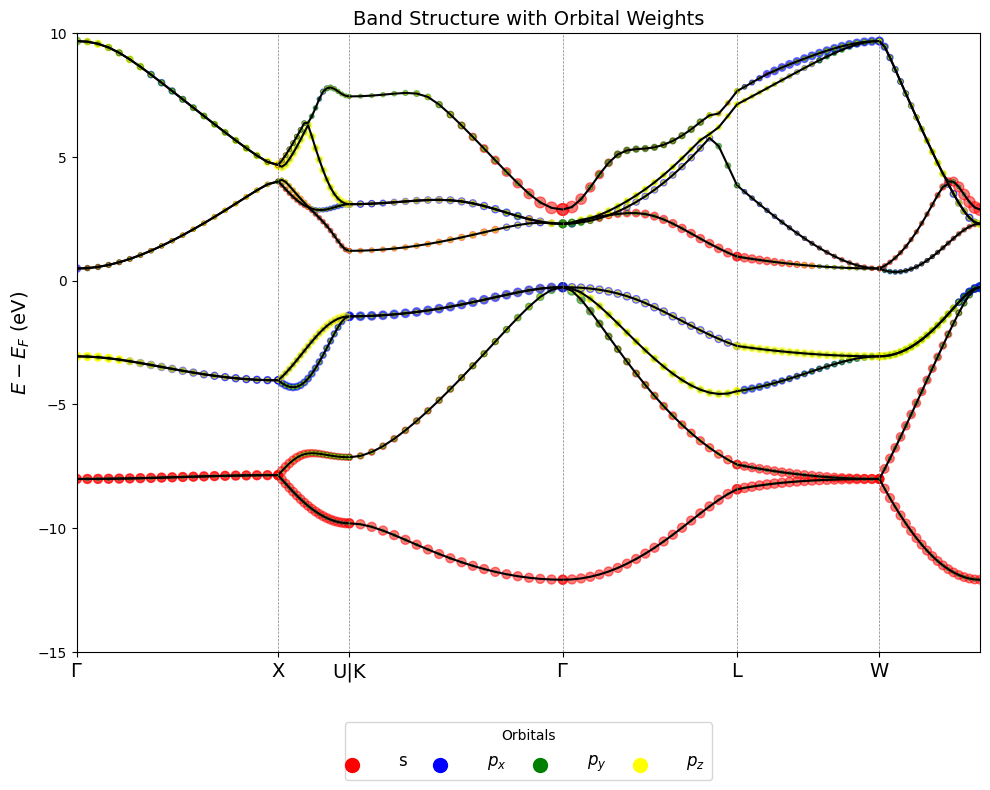

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D

# Function to read band structure and weights data from a .dat file
def read_band_structure_with_weights(filename):
    k_points = []
    energies = []
    weights = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

            # Read the second line for NKPTS and NBANDS
            nkpts = 0
            nbands = 0
            second_line_parts = lines[1].split()
            if len(second_line_parts) >= 6:
                nkpts = int(second_line_parts[4])  # Get NKPTS
                nbands = int(second_line_parts[5])  # Get NBANDS

            current_band_energies = []  # List to hold energies for the current band
            current_band_weights = []    # List to hold weights for the current band

            for line in lines:
                line = line.strip()  # Remove leading and trailing whitespace
                if line.startswith('#') or not line:  # Skip header lines and empty lines
                    continue

                parts = line.split()
                if len(parts) >= 2:  # Ensure there are at least k-point and energy
                    k_point = float(parts[0])
                    energy = float(parts[1])

                    # Append k-point and energy
                    k_points.append(k_point)
                    current_band_energies.append(energy)

                    # Collect the weights (remaining parts after energy)
                    current_band_weights.append(list(map(float, parts[2:])))

                    # If we've read nkpts energies, save them and start a new band
                    if len(current_band_energies) == nkpts:
                        energies.append(current_band_energies)  # Save the current band energies
                        weights.append(current_band_weights)      # Save the current band weights
                        current_band_energies = []  # Reset for the next band
                        current_band_weights = []    # Reset for the next band

        # Convert lists to NumPy arrays
        k_points = np.array(k_points[:nkpts])  # Keep only the first nkpts for k_points
        energies = np.array(energies)          # Convert energies to a 2D array
        weights = np.array(weights)             # Convert weights to a 3D array

        # Reverse the order of energies in even-indexed bands (0, 2, 4, ...)
        for band_index in range(energies.shape[0]):
            if band_index % 2 == 0:  # Reverse for even indexed bands (0, 2, 4, ...)
                energies[band_index] = energies[band_index][::-1]

        print(weights.shape)  # For debugging, show the shape of the weights
        return k_points, energies, weights  # Return k_points, energies, and weights
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None, None, None
    except ValueError as e:
        print(f"Error reading data: {e}")
        return None, None, None

# Function to read k-path labels and positions from a KLABELS file
def read_k_labels(filename):
    labels = []
    positions = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            # Skip the first line (comment line)
            for line in lines[1:]:  # Start from the second line
                line = line.strip()  # Remove any leading or trailing whitespace
                if not line:  # Skip empty lines
                    continue
                parts = line.split()
                if len(parts) == 2:
                    try:
                        label = parts[0]
                        # Replace "GAMMA" with LaTeX-style $\Gamma$
                        if label.upper() == "GAMMA":
                            label = r"$\Gamma$"
                        labels.append(label)
                        positions.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that don't have valid data
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return [], []

    return labels, positions

# Custom handler to set larger marker sizes in legend
class HandlerBigMarker(HandlerBase):
    def __init__(self, marker_size):
        self.marker_size = marker_size
        super().__init__()

    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        line = Line2D([x0], [y0], linestyle="none", marker=orig_handle.get_marker(),
                      color=orig_handle.get_color(), markersize=self.marker_size)
        return [line]

# Function to plot the band structure with weights and orbital legend
def plot_band_structure(k_points, energies, weights, k_labels, k_positions,
                        selected_orbitals=None, colors=None, orbital_labels=None,
                        font_size=12, line_thickness=1.5,
                        figure_size=(8, 6), energy_range=None, legend_marker_size=10):
    plt.figure(figsize=figure_size)

    # Default to all orbitals if none are selected
    if selected_orbitals is None:
        selected_orbitals = range(weights.shape[2])

    # Create a color map if none is provided
    if colors is None:
        colors = cm.viridis(np.linspace(0, 1, len(selected_orbitals)))

    # Default orbital labels if none provided
    if orbital_labels is None:
        orbital_labels = [f'Orbital {i}' for i in selected_orbitals]

    # Plot each band
    for band_index in range(energies.shape[0]):  # Iterate over each band
        plt.plot(k_points, energies[band_index], color='black', linewidth=line_thickness)

        # Plot weights for each selected orbital at this k-point
        for i, orbital_index in enumerate(selected_orbitals):
            scatter = plt.scatter(k_points, energies[band_index],
                                  s=weights[band_index, :, orbital_index] * 100,  # Scale size by weight
                                  color=colors[i % len(colors)], alpha=0.5,
                                  label=orbital_labels[i] if band_index == 0 else None)

    # Customize the plot
    #plt.xlabel('k-path', fontsize=font_size)
    plt.ylabel('$E-E_F$ (eV)', fontsize=font_size)
    plt.title('Band Structure with Orbital Weights', fontsize=font_size)

    # Set x-ticks at k-label positions
    plt.xticks(k_positions, k_labels, fontsize=font_size)

    # Draw vertical lines at k-label positions
    for pos in k_positions:
        plt.axvline(x=pos, color='gray', linestyle='--', linewidth=0.5)

    # Set energy range if provided
    if energy_range:
        plt.ylim(energy_range)
    plt.xlim(min(k_points), max(k_points))

        # Add a legend for the orbitals with larger marker sizes
    legend_handles = [plt.Line2D([0], [0], color=colors[i], marker='o', linestyle='None') for i in range(len(selected_orbitals))]
    plt.legend(handles=legend_handles, labels=orbital_labels,
               handler_map={legend_handles[i]: HandlerBigMarker(legend_marker_size) for i in range(len(legend_handles))},
               loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=font_size - 2, title='Orbitals', ncol=len(legend_handles))

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
band_file = 'PBAND_Si.dat'  # Replace with your .dat file name
klabels_file = 'KLABELS'  # Replace with your KLABELS file name

# Read data from files
k_points, energies, weights = read_band_structure_with_weights(band_file)
k_labels, k_positions = read_k_labels(klabels_file)

# Customize plot parameters as needed
if k_points is not None and energies is not None:
    # Select orbitals (for example: orbital 0 and 2) and define custom colors
    selected_orbitals = [0, 1, 2, 3]  # Specify which orbitals to plot
    custom_colors = ['red', 'blue', 'green', 'yellow']  # Specify colors for the selected orbitals
    orbital_labels = ['s', '$p_x$', '$p_y$', '$p_z$']  # Labels for the selected orbitals

    plot_band_structure(
        k_points, energies, weights, k_labels, k_positions,
        selected_orbitals=selected_orbitals, colors=custom_colors, orbital_labels=orbital_labels,
        font_size=14, line_thickness=1.5, figure_size=(10, 8),
        energy_range=(-15, 10),  # Adjust the energy range as needed
        legend_marker_size=10  # Set the legend marker size
    )

## **Spin polarised fat band**

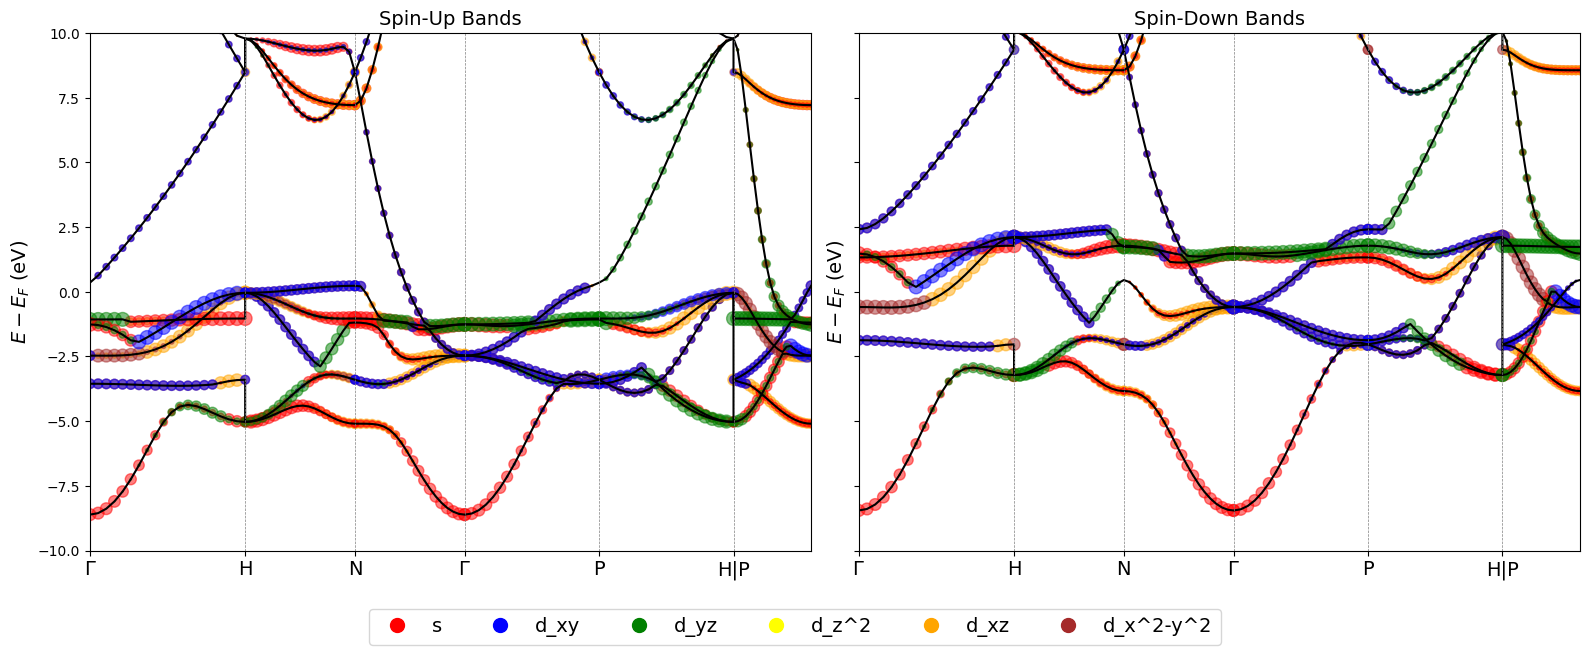

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to read band structure and weights data from a .dat file
def read_band_structure_with_weights(filename):
    k_points = []
    energies = []
    weights = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()

            # Read the second line for NKPTS and NBANDS
            nkpts = 0
            nbands = 0
            second_line_parts = lines[1].split()
            if len(second_line_parts) >= 6:
                nkpts = int(second_line_parts[4])  # Get NKPTS
                nbands = int(second_line_parts[5])  # Get NBANDS

            current_band_energies = []  # List to hold energies for the current band
            current_band_weights = []    # List to hold weights for the current band

            for line in lines:
                line = line.strip()  # Remove leading and trailing whitespace
                if line.startswith('#') or not line:  # Skip header lines and empty lines
                    continue

                parts = line.split()
                if len(parts) >= 2:  # Ensure there are at least k-point and energy
                    k_point = float(parts[0])
                    energy = float(parts[1])

                    # Append k-point and energy
                    k_points.append(k_point)
                    current_band_energies.append(energy)

                    # Collect the weights (remaining parts after energy)
                    current_band_weights.append(list(map(float, parts[2:])))

                    # If we've read nkpts energies, save them and start a new band
                    if len(current_band_energies) == nkpts:
                        energies.append(current_band_energies)  # Save the current band energies
                        weights.append(current_band_weights)      # Save the current band weights
                        current_band_energies = []  # Reset for the next band
                        current_band_weights = []    # Reset for the next band

        # Convert lists to NumPy arrays
        k_points = np.array(k_points[:nkpts])  # Keep only the first nkpts for k_points
        energies = np.array(energies)          # Convert energies to a 2D array
        weights = np.array(weights)             # Convert weights to a 3D array

        return k_points, energies, weights  # Return k_points, energies, and weights
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return None, None, None
    except ValueError as e:
        print(f"Error reading data: {e}")
        return None, None, None

# Function to read k-path labels and positions from a KLABELS file
def read_k_labels(filename):
    labels = []
    positions = []

    try:
        with open(filename, 'r') as file:
            lines = file.readlines()
            # Skip the first line (comment line)
            for line in lines[1:]:  # Start from the second line
                line = line.strip()  # Remove any leading or trailing whitespace
                if not line:  # Skip empty lines
                    continue
                parts = line.split()
                if len(parts) == 2:
                    try:
                        label = parts[0]
                        # Replace "GAMMA" with LaTeX-style $\Gamma$
                        if label.upper() == "GAMMA":
                            label = r"$\Gamma$"
                        labels.append(label)
                        positions.append(float(parts[1]))
                    except ValueError:
                        continue  # Skip lines that don't have valid data
    except FileNotFoundError:
        print(f"Error: File {filename} not found.")
        return [], []

    return labels, positions

# Function to plot spin-polarized band structure
def plot_spin_polarized_bands(k_points_up, energies_up, weights_up,
                              k_points_down, energies_down, weights_down,
                              k_labels, k_positions, selected_orbitals=None,
                              colors=None, font_size=12, line_thickness=1.5,
                              figure_size=(16, 6), energy_range=None,
                              orbital_labels=None):
    fig, axes = plt.subplots(1, 2, figsize=figure_size, sharey=True)

    # Default to all orbitals if none are selected
    if selected_orbitals is None:
        selected_orbitals = range(weights_up.shape[2])

    # Create a color map if none is provided
    if colors is None:
        colors = cm.viridis(np.linspace(0, 1, len(selected_orbitals)))

    # Plot spin-up bands
    axes[0].set_title('Spin-Up Bands', fontsize=font_size)
    for band_index in range(energies_up.shape[0]):
        axes[0].plot(k_points_up, energies_up[band_index], color='black', linewidth=line_thickness)
        for orbital_index in selected_orbitals:
            axes[0].scatter(k_points_up, energies_up[band_index],
                            s=weights_up[band_index, :, orbital_index] * 100,
                            color=colors[orbital_index % len(colors)], alpha=0.5)

    # Plot spin-down bands
    axes[1].set_title('Spin-Down Bands', fontsize=font_size)
    for band_index in range(energies_down.shape[0]):
        axes[1].plot(k_points_down, energies_down[band_index], color='black', linewidth=line_thickness)
        for orbital_index in selected_orbitals:
            axes[1].scatter(k_points_down, energies_down[band_index],
                            s=weights_down[band_index, :, orbital_index] * 100,
                            color=colors[orbital_index % len(colors)], alpha=0.5)

    # Customize both plots
    for ax in axes:
        #ax.set_xlabel('k-path', fontsize=font_size)
        ax.set_ylabel('$E-E_F$ (eV)', fontsize=font_size)
        ax.set_xticks(k_positions)
        ax.set_xticklabels(k_labels, fontsize=font_size)
        for pos in k_positions:
            ax.axvline(x=pos, color='gray', linestyle='--', linewidth=0.5)

    # Set energy range if provided
    if energy_range:
        axes[0].set_ylim(energy_range)
    ax.set_xlim(min(k_points_up), max(k_points_up))
    axes[0].set_xlim(min(k_points_up), max(k_points_up))

    # Create custom legend with larger markers for orbitals
    if orbital_labels:
        legend_handles = [
            plt.Line2D([], [], marker='o', color=color, linestyle='None', markersize=10, label=label)
            for color, label in zip(colors, orbital_labels)
        ]
        fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.1),
                   fontsize=font_size, ncol=len(legend_handles))

    plt.tight_layout()
    plt.show()

# Example usage
band_file_up = 'PBAND_Fe_UP.dat'    # Replace with your spin-up .dat file name
band_file_down = 'PBAND_Fe_DW.dat'  # Replace with your spin-down .dat file name
klabels_file = 'KLABELS'             # Replace with your KLABELS file name

# Read data from files
k_points_up, energies_up, weights_up = read_band_structure_with_weights(band_file_up)
k_points_down, energies_down, weights_down = read_band_structure_with_weights(band_file_down)
k_labels, k_positions = read_k_labels(klabels_file)

# Plot the spin-polarized bands if data is successfully loaded
if k_points_up is not None and k_points_down is not None:
    selected_orbitals = [0, 4, 5, 6, 7, 8]  # Assuming these indices correspond to the "s" and "d" orbitals
    custom_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'brown']  # Colors for each orbital
    orbital_labels = ['s', 'd_xy', 'd_yz', 'd_z^2', 'd_xz', 'd_x^2-y^2']  # Labels for "s" and "d" orbitals

    plot_spin_polarized_bands(
        k_points_up, energies_up, weights_up,
        k_points_down, energies_down, weights_down,
        k_labels, k_positions,
        selected_orbitals=selected_orbitals, colors=custom_colors,
        font_size=14, line_thickness=1.5, figure_size=(16, 6),
        energy_range=(-10, 10), orbital_labels=orbital_labels
    )